# Setup environment

In [23]:
import collections
import copy
from concurrent import futures
import json
import random
import shutil
import sys
import tqdm.notebook


from urllib import request
from matplotlib import gridspec
import matplotlib.pyplot as plt
import numpy as np
import py3Dmol

from alphafold.model import model
from alphafold.model import config
from alphafold.model import data

from alphafold.data import feature_processing
from alphafold.data import msa_pairing
from alphafold.data import pipeline
from alphafold.data import pipeline_multimer
from alphafold.data.tools import jackhmmer

from alphafold.common import protein

from alphafold.relax import relax
from alphafold.relax import utils

from IPython import display
from ipywidgets import GridspecLayout
from ipywidgets import Output

In [24]:
import os
os.environ['TF_FORCE_UNIFIED_MEMORY'] = '1'
os.environ['XLA_PYTHON_CLIENT_MEM_FRACTION'] = '4.0'

## Fix a dependency issue
- stereo_chemical_props.txt
- openmm.patch

In [25]:
# ! wget -q -P content https://git.scicore.unibas.ch/schwede/openstructure/-/raw/7102c63615b64735c4941278d92b554ec94415f8/modules/mol/alg/src/stereo_chemical_props.txt
# ! cp  content/stereo_chemical_props.txt /home/xiaopeng/Desktop/Prot_struct/Prot_struct_pred/ref_works/alphafold/env/lib/python3.8/site-packages/alphafold-2.3.1-py3.8.egg/alphafold/common/stereo_chemical_props.txt

In [26]:
# Apply OpenMM patch.
# ! pushd content/site-packages/site-packages/ && patch -p0 < content/alphafold/docker/openmm.patch && popd
# ! mkdir -p content/alphafold/alphafold/common
# ! cp -f content/stereo_chemical_props.txt content/alphafold/alphafold/common
# ! mkdir -p content/site-packages/alphafold/common/
# ! cp -f content/stereo_chemical_props.txt content/site-packages/alphafold/common/

# sys.path.append('content/alphafold')

## Download pretrained models

In [27]:
# GIT_REPO = 'https://github.com/deepmind/alphafold'
# SOURCE_URL = 'https://storage.googleapis.com/alphafold/alphafold_params_colab_2022-12-06.tar'
# PARAMS_DIR = './alphafold/data/params'
# PARAMS_PATH = os.path.join(PARAMS_DIR, os.path.basename(SOURCE_URL))

# ! mkdir --parents "{PARAMS_DIR}"
# ! wget -O "{PARAMS_PATH}" "{SOURCE_URL}"
# ! tar --extract --verbose --file="{PARAMS_PATH}"  --directory="{PARAMS_DIR}" --preserve-permissions
# ! rm "{PARAMS_PATH}"

# Make a prediction

## Enter the amino acid sequence(s) to fold.

- If you enter only a single sequence, the monomer model will be used (unless you override this below).
- If you enter multiple sequences, the multimer model will be used.

In [28]:
from alphafold.notebooks import notebook_utils
import enum

@enum.unique
class ModelType(enum.Enum):
  MONOMER = 0
  MULTIMER = 1

def clean_sequence(input_sequences, min_len=16, max_len=4000):
  # Validate the input sequences.
  sequences = notebook_utils.clean_and_validate_input_sequences(
    input_sequences=input_sequences, 
    min_sequence_length=min_len, 
    max_sequence_length=max_len)
  return sequences

def get_model_type(sequences, use_multimer_model_for_monomers=False):
  """Returns the model type to use for the given input sequences."""
  if len(sequences) == 1:
    if use_multimer_model_for_monomers:
      print('Using the multimer model for single-chain, as requested.')
      model_type_to_use = ModelType.MULTIMER
    else:
      print('Using the single-chain model.')
      model_type_to_use = ModelType.MONOMER
  else:
    print(f'Using the multimer model with {len(sequences)} sequences.')
    model_type_to_use = ModelType.MULTIMER
  return model_type_to_use

def check_total_length(sequences, max_len=4000, max_valid_len=3000):
  """Checks the total sequence length is within the valid range."""

  # Check whether total length exceeds limit.
  total_sequence_length = sum([len(seq) for seq in sequences])
  if total_sequence_length > max_len:
    raise ValueError('The total sequence length is too long: '
                    f'{total_sequence_length}, while the maximum is '
                    f'{max_len}.')
  
  if total_sequence_length > max_valid_len:
    print('WARNING: The accuracy of the system has not been fully validated '
          'above 3000 residues, and you may experience long running times or '
          f'run out of memory. Total sequence length is {total_sequence_length} '
          'residues.')

def check_monomer_length(sequences, model_type_to_use, max_monomer_len=2500):
  # Check whether we exceed the monomer limit.
  if model_type_to_use == ModelType.MONOMER:
    if len(sequences[0]) > max_monomer_len:
      raise ValueError(
          f'Input sequence is too long: {len(sequences[0])} amino acids, while '
          f'the maximum for the monomer model is {max_monomer_len}. You may '
          'be able to run this sequence with the multimer model by selecting the '
          'use_multimer_model_for_monomers checkbox above.')


In [29]:
# Example
# sequence_1 = 'MAAHKGAEHHHKAAEHHEQAAKHHHAAAEHHEKGEHEQAAHHADTAYAHHKHAEEHAAQAAKHDAEHHAPKPH'
# sequence_2 = ''
# sequence_3 = ''

# input_sequences = (sequence_1, sequence_2, sequence_3)
# sequences = clean_sequence(input_sequences)
# model_type_to_use = get_model_type(sequences)
# check_total_length(sequences)
# check_monomer_length(sequences, model_type_to_use)

## Search against genetic databases

In [30]:
JACKHMMER_BINARY_PATH = '/home/xiaopeng/Desktop/Prot_struct/Prot_struct_pred/ref_works/alphafold/env/bin/jackhmmer'
DB_ROOT_PATH = f'/home/xiaopeng/Desktop/Prot_struct/Prot_struct_pred/ref_works/alphafold/seq_dbs/'

def get_msa_databases(sequences, model_type_to_use):
    msa_dbs = [
        {'db_name': 'uniref100',
        'db_path': f'{DB_ROOT_PATH}uniref100.fasta',
        'num_streamed_chunks': 1,
        'z_value': 297_827_854}, # The z_value is the number of sequences in a database.
        {'db_name': 'smallbfd',
        'db_path': f'{DB_ROOT_PATH}bfd-first_non_consensus_sequences.fasta',
        'num_streamed_chunks': 1,
        'z_value': 65_984_053},
        {'db_name': 'mgnify',
        'db_path': f'{DB_ROOT_PATH}mgy_clusters_2022_05.fa',
        'num_streamed_chunks': 1,
        'z_value': 623_796_864},
    ]
    # Search UniProt and construct the all_seq features only for heteromers, not homomers.
    if model_type_to_use == ModelType.MULTIMER and len(set(sequences)) > 1:
        msa_dbs.extend([
            # Swiss-Prot and TrEMBL are concatenated together as UniProt.
            {'db_name': 'uniprot',
            'db_path': f'{DB_ROOT_PATH}uniprot.fasta',
            'num_streamed_chunks': 101,
            'z_value': 225_013_025 + 565_928},
        ])
    
    return msa_dbs

MAX_HITS = {
    'uniref90': 10_000,
    'smallbfd': 5_000,
    'mgnify': 501,
    'uniprot': 50_000,
}

In [31]:
TQDM_BAR_FORMAT = '{l_bar}{bar}| {n_fmt}/{total_fmt} [elapsed: {elapsed} remaining: {remaining}]'

def get_msa(sequences, msa_dbs, prefix=''):
  """Searches for MSA for given sequences using chunked Jackhmmer search.
  
  Args:
    sequences: A list of sequences to search against all databases.

  Returns:
    A dictionary mapping unique sequences to dicionaries mapping each database
    to a list of  results, one for each chunk of the database.
  """
  jackhmm_chunks = sum([cfg['num_streamed_chunks'] for cfg in msa_dbs])

  sequence_to_fasta_path = {}
  # Deduplicate to not do redundant work for multiple copies of the same chain in homomers.
  for sequence_index, sequence in enumerate(sorted(set(sequences)), 1):
    fasta_path = f'{prefix}target_{sequence_index:02d}.fasta'
    with open(fasta_path, 'wt') as f:
      f.write(f'>query\n{sequence}')
    sequence_to_fasta_path[sequence] = fasta_path

  # Run the search against chunks of genetic databases (since the genetic
  # databases don't fit in Colab disk).
  raw_msa_results = {sequence: {} for sequence in sequence_to_fasta_path.keys()}
  print('\nGetting MSA for all sequences')
  with tqdm.notebook.tqdm(total=jackhmm_chunks, bar_format=TQDM_BAR_FORMAT) as pbar:
    def jackhmmer_chunk_callback(i):
      pbar.update(n=1)

    for db_config in msa_dbs:
      db_name = db_config['db_name']
      pbar.set_description(f'Searching {db_name}')
      jackhmmer_runner = jackhmmer.Jackhmmer(
          binary_path=JACKHMMER_BINARY_PATH,
          database_path=db_config['db_path'],
          get_tblout=True,
          # num_streamed_chunks=db_config['num_streamed_chunks'],
          streaming_callback=jackhmmer_chunk_callback,
          z_value=db_config['z_value'])
      # Query all unique sequences against each chunk of the database to prevent
      # redunantly fetching each chunk for each unique sequence.
      results = jackhmmer_runner.query_multiple(list(sequence_to_fasta_path.values()))
      for sequence, result_for_sequence in zip(sequence_to_fasta_path.keys(), results):
        raw_msa_results[sequence][db_name] = result_for_sequence

  return raw_msa_results

In [64]:
def get_features_for_chain(sequences, raw_msa_results_for_sequence, model_type_to_use):
  features_for_chain = {}
  print(len(sequences))
  for sequence_index, sequence in enumerate(sequences, start=1):
    raw_msa_results = copy.deepcopy(raw_msa_results_for_sequence[sequence])

    # Extract the MSAs from the Stockholm files.
    # NB: deduplication happens later in pipeline.make_msa_features.
    single_chain_msas = []
    uniprot_msa = None
    for db_name, db_results in raw_msa_results.items():
      merged_msa = notebook_utils.merge_chunked_msa(
          results=db_results, max_hits=MAX_HITS.get(db_name))
      if merged_msa.sequences and db_name != 'uniprot':
        single_chain_msas.append(merged_msa)
        msa_size = len(set(merged_msa.sequences))
        print(f'{msa_size} unique sequences found in {db_name} for sequence {sequence_index}')
      elif merged_msa.sequences and db_name == 'uniprot':
        uniprot_msa = merged_msa

    notebook_utils.show_msa_info(single_chain_msas=single_chain_msas, sequence_index=sequence_index)

    # Turn the raw data into model features.
    feature_dict = {}
    feature_dict.update(pipeline.make_sequence_features(
        sequence=sequence, description='query', num_res=len(sequence)))
    feature_dict.update(pipeline.make_msa_features(msas=single_chain_msas))
    # We don't use templates in AlphaFold Colab notebook, add only empty placeholder features.
    feature_dict.update(notebook_utils.empty_placeholder_template_features(
        num_templates=0, num_res=len(sequence)))

    # Construct the all_seq features only for heteromers, not homomers.
    if model_type_to_use == ModelType.MULTIMER and len(set(sequences)) > 1:
      valid_feats = msa_pairing.MSA_FEATURES + (
          'msa_species_identifiers',
      )
      all_seq_features = {
          f'{k}_all_seq': v for k, v in pipeline.make_msa_features([uniprot_msa]).items()
          if k in valid_feats}
      feature_dict.update(all_seq_features)

    features_for_chain[protein.PDB_CHAIN_IDS[sequence_index - 1]] = feature_dict

  return features_for_chain


In [55]:
# msa_dbs =  get_msa_databases(sequences, model_type_to_use)
# raw_msa_results_for_sequence = get_msa(sequences, msa_dbs)

3
9391 unique sequences found in uniref100 for sequence 1
235 unique sequences found in smallbfd for sequence 1
142 unique sequences found in mgnify for sequence 1

9564 unique sequences found in total for sequence 1



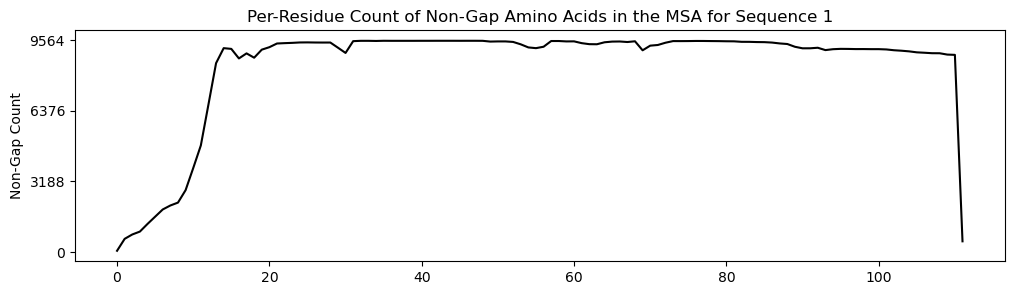

30929 unique sequences found in uniref100 for sequence 2
213 unique sequences found in smallbfd for sequence 2
483 unique sequences found in mgnify for sequence 2

31506 unique sequences found in total for sequence 2



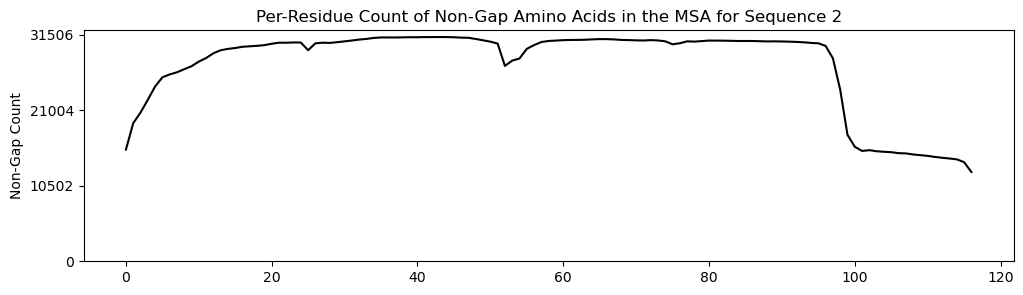

33210 unique sequences found in uniref100 for sequence 3
302 unique sequences found in smallbfd for sequence 3
490 unique sequences found in mgnify for sequence 3

33803 unique sequences found in total for sequence 3



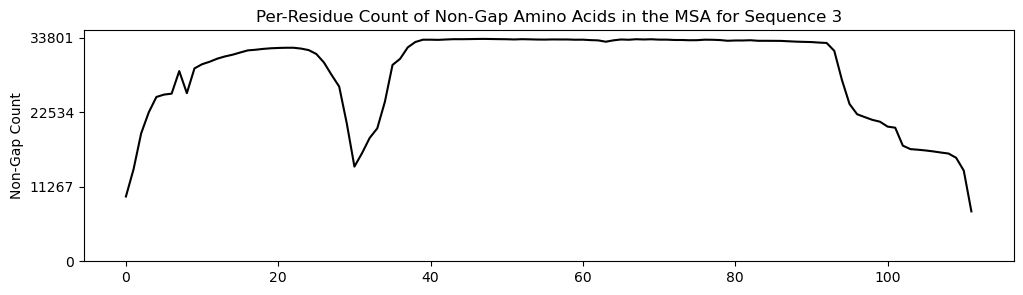

(3, 3)

In [65]:
# features_for_chain = get_features_for_chain(sequences, raw_msa_results_for_sequence, model_type_to_use)
# len(sequences), len(features_for_chain.keys())

In [35]:
def post_process_features(features_for_chain, model_type_to_use):
  """Post-processes features for each chain."""
  # Do further feature post-processing depending on the model type.
  if model_type_to_use == ModelType.MONOMER:
    np_example = features_for_chain[protein.PDB_CHAIN_IDS[0]]

  elif model_type_to_use == ModelType.MULTIMER:
    all_chain_features = {}
    for chain_id, chain_features in features_for_chain.items():
      all_chain_features[chain_id] = pipeline_multimer.convert_monomer_features(
          chain_features, chain_id)

    all_chain_features = pipeline_multimer.add_assembly_features(all_chain_features)

    np_example = feature_processing.pair_and_merge(
        all_chain_features=all_chain_features)

    # Pad MSA to avoid zero-sized extra_msa.
    np_example = pipeline_multimer.pad_msa(np_example, min_num_seq=512)

  return np_example

In [36]:
# np_example = post_process_features(features_for_chain, model_type_to_use)

## Run AlphaFold and save prediction

In [37]:
def run_model_pred(model_type_to_use, np_example, multimer_model_max_num_recycles=3, run_relax=True, relax_use_gpu=False):

  if model_type_to_use == ModelType.MONOMER:
    model_names = config.MODEL_PRESETS['monomer'] + ('model_2_ptm',)
  elif model_type_to_use == ModelType.MULTIMER:
    model_names = config.MODEL_PRESETS['multimer']

  plddts = {}
  ranking_confidences = {}
  pae_outputs = {}
  unrelaxed_proteins = {}

  with tqdm.notebook.tqdm(total=len(model_names) + 1, bar_format=TQDM_BAR_FORMAT) as pbar:
    for model_name in model_names:
      pbar.set_description(f'Running {model_name}')

      cfg = config.model_config(model_name)

      if model_type_to_use == ModelType.MONOMER:
        cfg.data.eval.num_ensemble = 1
      elif model_type_to_use == ModelType.MULTIMER:
        cfg.model.num_ensemble_eval = 1

      if model_type_to_use == ModelType.MULTIMER:
        cfg.model.num_recycle = multimer_model_max_num_recycles
        cfg.model.recycle_early_stop_tolerance = 0.5

      params = data.get_model_haiku_params(model_name, './alphafold/data')
      model_runner = model.RunModel(cfg, params)
      processed_feature_dict = model_runner.process_features(np_example, random_seed=0)
      prediction = model_runner.predict(processed_feature_dict, random_seed=random.randrange(sys.maxsize))

      mean_plddt = prediction['plddt'].mean()

      if model_type_to_use == ModelType.MONOMER:
        if 'predicted_aligned_error' in prediction:
          pae_outputs[model_name] = (prediction['predicted_aligned_error'],
                                    prediction['max_predicted_aligned_error'])
        else:
          # Monomer models are sorted by mean pLDDT. Do not put monomer pTM models here as they
          # should never get selected.
          ranking_confidences[model_name] = prediction['ranking_confidence']
          plddts[model_name] = prediction['plddt']
      elif model_type_to_use == ModelType.MULTIMER:
        # Multimer models are sorted by pTM+ipTM.
        ranking_confidences[model_name] = prediction['ranking_confidence']
        plddts[model_name] = prediction['plddt']
        pae_outputs[model_name] = (prediction['predicted_aligned_error'],
                                  prediction['max_predicted_aligned_error'])

      # Set the b-factors to the per-residue plddt.
      final_atom_mask = prediction['structure_module']['final_atom_mask']
      b_factors = prediction['plddt'][:, None] * final_atom_mask
      unrelaxed_protein = protein.from_prediction(
          processed_feature_dict,
          prediction,
          b_factors=b_factors,
          remove_leading_feature_dimension=(
              model_type_to_use == ModelType.MONOMER))
      unrelaxed_proteins[model_name] = unrelaxed_protein

      # Delete unused outputs to save memory.
      del model_runner
      del params
      del prediction
      pbar.update(n=1)

    # Find the best model according to the mean pLDDT.
    best_model_name = max(ranking_confidences.keys(), key=lambda x: ranking_confidences[x])
    
    # --- AMBER relax the best model ---
    # Relaxation is faster with a GPU, but we have found it to be less stable.
    if run_relax:
      pbar.set_description(f'AMBER relaxation')
      amber_relaxer = relax.AmberRelaxation(
            max_iterations=0,
            tolerance=2.39,
            stiffness=10.0,
            exclude_residues=[],
            max_outer_iterations=3,
            use_gpu=relax_use_gpu)
      relaxed_pdb, _, _ = amber_relaxer.process(prot=unrelaxed_proteins[best_model_name])
    else:
      print('Warning: Running without the relaxation stage.')
      relaxed_pdb = protein.to_pdb(unrelaxed_proteins[best_model_name])
  
    pbar.update(n=1)  # Finished AMBER relax.
  return plddts, best_model_name, final_atom_mask, relaxed_pdb, pae_outputs, unrelaxed_proteins

In [38]:
# plddts, best_model_name, final_atom_mask, relaxed_pdb, pae_outputs, unrelaxed_proteins = run_model_pred(model_type_to_use, np_example, output_dir='prediction')

## Visualize the predicted structure

In [39]:
# Color bands for visualizing plddt
PLDDT_BANDS = [(0, 50, '#FF7D45'),
               (50, 70, '#FFDB13'),
               (70, 90, '#65CBF3'),
               (90, 100, '#0053D6')]

def get_pdb_confidence(relaxed_pdb, plddts, best_model_name, final_atom_mask):
  # Construct multiclass b-factors to indicate confidence bands
  # 0=very low, 1=low, 2=confident, 3=very high
  banded_b_factors = []
  for plddt in plddts[best_model_name]:
    for idx, (min_val, max_val, _) in enumerate(PLDDT_BANDS):
      if plddt >= min_val and plddt <= max_val:
        banded_b_factors.append(idx)
        break
  banded_b_factors = np.array(banded_b_factors)[:, None] * final_atom_mask
  to_visualize_pdb = utils.overwrite_b_factors(relaxed_pdb, banded_b_factors)
  return to_visualize_pdb

def plot_plddt_legend():
  """Plots the legend for pLDDT."""
  thresh = ['Very low (pLDDT < 50)', 'Low (70 > pLDDT > 50)', 'Confident (90 > pLDDT > 70)', 'Very high (pLDDT > 90)']

  colors = [x[2] for x in PLDDT_BANDS]

  plt.figure(figsize=(2, 2))
  for c in colors:
    plt.bar(0, 0, color=c)
  plt.legend(thresh, frameon=False, loc='center', fontsize=20)
  plt.xticks([])
  plt.yticks([])
  ax = plt.gca()
  ax.spines['right'].set_visible(False)
  ax.spines['top'].set_visible(False)
  ax.spines['left'].set_visible(False)
  ax.spines['bottom'].set_visible(False)
  plt.title('Model Confidence', fontsize=20, pad=20)
  return plt

def visualize_structure(to_visualize_pdb, model_type_to_use, show_sidechains=True):
    # Show the structure coloured by chain if the multimer model has been used.
    if model_type_to_use == ModelType.MULTIMER:
        multichain_view = py3Dmol.view(width=800, height=600)
        multichain_view.addModelsAsFrames(to_visualize_pdb)
        multichain_style = {'cartoon': {'colorscheme': 'chain'}}
        multichain_view.setStyle({'model': -1}, multichain_style)
        multichain_view.zoomTo()
        multichain_view.show()

    # Color the structure by per-residue pLDDT
    color_map = {i: bands[2] for i, bands in enumerate(PLDDT_BANDS)}
    view = py3Dmol.view(width=800, height=600)
    view.addModelsAsFrames(to_visualize_pdb)
    style = {'cartoon': {'colorscheme': {'prop': 'b', 'map': color_map}}}
    if show_sidechains:
        style['stick'] = {}
    view.setStyle({'model': -1}, style)
    view.zoomTo()

    grid = GridspecLayout(1, 2)
    out = Output()
    with out:
        view.show()
    grid[0, 0] = out

    out = Output()
    with out:
        plot_plddt_legend().show()
    grid[0, 1] = out

    display.display(grid)

def display_plddt_and_pae(plddts, pae_outputs, unrelaxed_proteins, best_model_name):
  # Display pLDDT and predicted aligned error (if output by the model).
  num_plots = 2 if pae_outputs else 1

  plt.figure(figsize=[8 * num_plots, 6])
  plt.subplot(1, num_plots, 1)
  plt.plot(plddts[best_model_name])
  plt.title('Predicted LDDT')
  plt.xlabel('Residue')
  plt.ylabel('pLDDT')

  if num_plots == 2:
    plt.subplot(1, 2, 2)
    pae, max_pae = list(pae_outputs.values())[0]
    plt.imshow(pae, vmin=0., vmax=max_pae, cmap='Greens_r')
    plt.colorbar(fraction=0.046, pad=0.04)

    # Display lines at chain boundaries.
    best_unrelaxed_prot = unrelaxed_proteins[best_model_name]
    total_num_res = best_unrelaxed_prot.residue_index.shape[-1]
    chain_ids = best_unrelaxed_prot.chain_index
    for chain_boundary in np.nonzero(chain_ids[:-1] - chain_ids[1:]):
      if chain_boundary.size:
        plt.plot([0, total_num_res], [chain_boundary, chain_boundary], color='red')
        plt.plot([chain_boundary, chain_boundary], [0, total_num_res], color='red')

    plt.title('Predicted Aligned Error')
    plt.xlabel('Scored residue')
    plt.ylabel('Aligned residue')
  return pae, max_pae

In [40]:
def save_results(relaxed_pdb, pae_outputs, pae, max_pae, output_dir='prediction'):
    os.makedirs(output_dir, exist_ok=True)

    # Write out the prediction
    pred_output_path = os.path.join(output_dir, 'selected_prediction.pdb')
    with open(pred_output_path, 'w') as f:
      f.write(relaxed_pdb)

    # Save the predicted aligned error (if it exists).
    pae_output_path = os.path.join(output_dir, 'predicted_aligned_error.json')
    if pae_outputs:
      # Save predicted aligned error in the same format as the AF EMBL DB.
      pae_data = notebook_utils.get_pae_json(pae=pae, max_pae=max_pae.item())
      with open(pae_output_path, 'w') as f:
        f.write(pae_data)
    

In [41]:
# to_visualize_pdb = get_pdb_confidence(relaxed_pdb, plddts, best_model_name, final_atom_mask)
# visualize_structure(to_visualize_pdb, model_type_to_use)

In [42]:
# pae, max_pae = display_plddt_and_pae(plddts, pae_outputs, unrelaxed_proteins, best_model_name)
# save_results(relaxed_pdb, pae_outputs, pae, max_pae, output_dir='prediction/test')

# Final run


In [43]:
def run_alphafold(input_sequences, output_dir='prediction/test'):
    sequences = clean_sequence(input_sequences)
    model_type_to_use = get_model_type(sequences)
    check_total_length(sequences)
    check_monomer_length(sequences, model_type_to_use)

    msa_dbs =  get_msa_databases(sequences, model_type_to_use)
    raw_msa_results_for_sequence = get_msa(sequences, msa_dbs, prefix=output_dir)

    features_for_chain = get_features_for_chain(sequences, raw_msa_results_for_sequence, model_type_to_use)
    np_example = post_process_features(features_for_chain, model_type_to_use)
    plddts, best_model_name, final_atom_mask, relaxed_pdb, pae_outputs, unrelaxed_proteins = run_model_pred(model_type_to_use, np_example)

    to_visualize_pdb = get_pdb_confidence(relaxed_pdb, plddts, best_model_name, final_atom_mask)
    visualize_structure(to_visualize_pdb, model_type_to_use)

    pae, max_pae = display_plddt_and_pae(plddts, pae_outputs, unrelaxed_proteins, best_model_name)
    save_results(relaxed_pdb, pae_outputs, pae, max_pae, output_dir)


In [45]:
# Example
sequence_1 = 'ARNGDHCPLGPGRCCRLHTVRASLEDLGWADWVLSPREVQVTMCIGACPSQFRAANMHAQIKTSLHRLKPDTVPAPCCVPASYNPMVLIQKTDTGVSLQTYDDLLAKDCHCI'
sequence_2 = 'QVQVVQSGAEVKMPGASVKVSCKASVYTFTGYYIHWVRQAPGQGLEWMGRISPNSADTTYAQKFQGRITMTRDTSINTAFMELNRLRSDDTAVYYCARGVELHFDYWGQGTLVTVSS'
sequence_3 = 'DIVMTQSPLSLPVTPGEPASISCRSSQSLLYSNGYNYLDWYLQKPGQSPQLLIYLGSNRASGVPDRFSGSGSGTDFTLKISRVEAEDVGVYYCMQALQTPLTFGGGTRLEIK'

input_sequences = (sequence_1, sequence_2, sequence_3)
output_dir='prediction/167-02'

# run_alphafold(input_sequences, output_dir)

In [46]:
sequences = clean_sequence(input_sequences)
model_type_to_use = get_model_type(sequences)
check_total_length(sequences)
check_monomer_length(sequences, model_type_to_use)

msa_dbs =  get_msa_databases(sequences, model_type_to_use)
raw_msa_results_for_sequence = get_msa(sequences, msa_dbs, prefix=output_dir)

Using the multimer model with 3 sequences.

Getting MSA for all sequences


  0%|          | 0/104 [elapsed: 00:00 remaining: ?]

3
9391 unique sequences found in uniref100 for sequence 1
235 unique sequences found in smallbfd for sequence 1
142 unique sequences found in mgnify for sequence 1

9564 unique sequences found in total for sequence 1



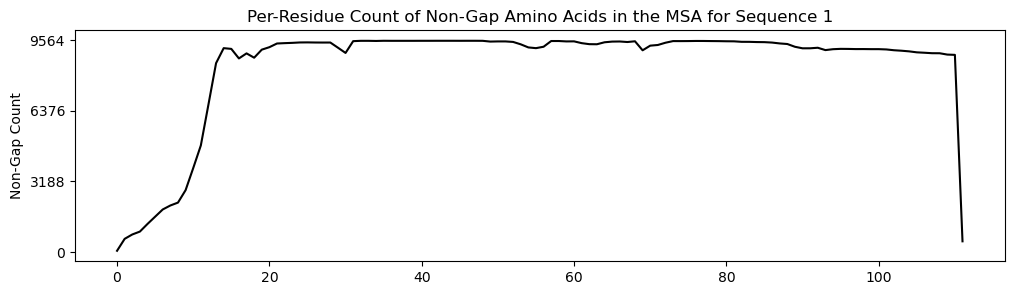

30929 unique sequences found in uniref100 for sequence 2
213 unique sequences found in smallbfd for sequence 2
483 unique sequences found in mgnify for sequence 2

31506 unique sequences found in total for sequence 2



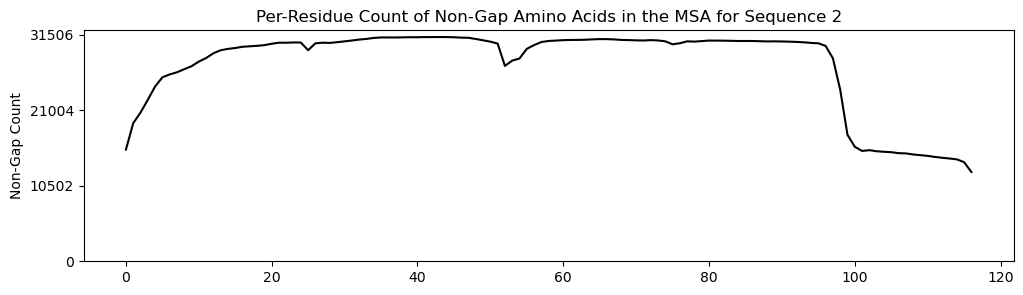

33210 unique sequences found in uniref100 for sequence 3
302 unique sequences found in smallbfd for sequence 3
490 unique sequences found in mgnify for sequence 3

33803 unique sequences found in total for sequence 3



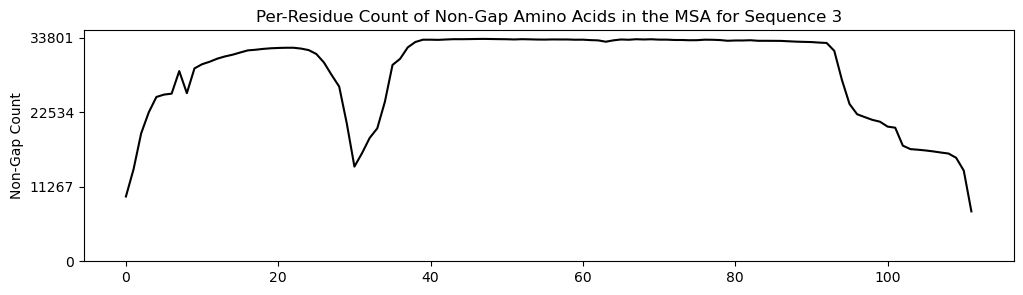

  0%|          | 0/6 [elapsed: 00:00 remaining: ?]

In [66]:
features_for_chain = get_features_for_chain(sequences, raw_msa_results_for_sequence, model_type_to_use)
np_example = post_process_features(features_for_chain, model_type_to_use)
plddts, best_model_name, final_atom_mask, relaxed_pdb, pae_outputs, unrelaxed_proteins = run_model_pred(model_type_to_use, np_example)

to_visualize_pdb = get_pdb_confidence(relaxed_pdb, plddts, best_model_name, final_atom_mask)
visualize_structure(to_visualize_pdb, model_type_to_use)

pae, max_pae = display_plddt_and_pae(plddts, pae_outputs, unrelaxed_proteins, best_model_name)
save_results(relaxed_pdb, pae_outputs, pae, max_pae, output_dir)